In [501]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

# Dataset analyzing.

Read titanic data from files.

In [502]:
df = pd.read_csv('data/titanic/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Survived men and women visualization.

During the titanic dataset analyzing we can define a fact, that probability to survive for men is
far less than for women (~21% vs ~75%). I think that the reason for this situation is that women were the first to be
put in lifeboats.
We also can declare that men have a high probability of survival when they are between 18 and 30 years old,
For women the survival chances are higher for ages between 14 and 40.

Female: Survived 197. Not survived 64.
Male: Survived 93. Not survived 360.


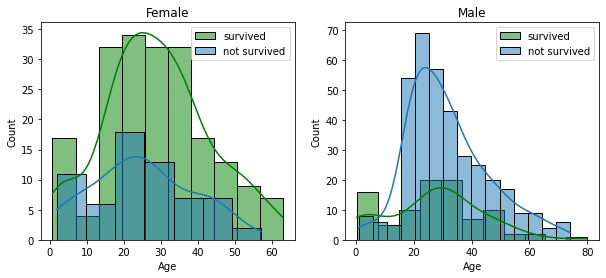

In [503]:
sex_list = ['female', 'male']
fig, axes = plt.subplots(ncols=2, figsize=(10, 4))
for axis, sex in zip(axes, sex_list):
    sex_df = df[df['Sex']==sex]
    survived = sex_df[sex_df['Survived']==1].Age.dropna()
    not_survived = sex_df[sex_df['Survived']==0].Age.dropna()
    ax = sns.histplot(data=survived, label='survived', color='green', ax=axis, kde=True)
    sns.histplot(data=not_survived, label='not survived', ax=axis, kde=True)
    ax.legend()
    sex = sex.title()
    ax.set_title(sex)
    print(f'{sex}: Survived {len(survived)}. Not survived {len(not_survived)}.')

Dependency between passenger class and ability to survive.

As you can see, passengers with first class had a much more chances
to survive (especially comparing to a third class).

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

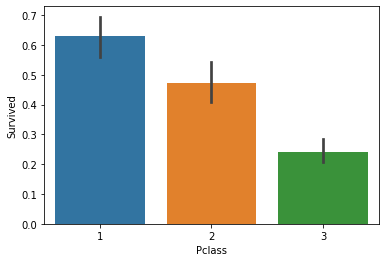

In [504]:
sns.barplot(x='Pclass', y='Survived', data=df)

Below is another plot that shows dependency described on the previous one histogram.
As was mentioned on the previous step it is a high probability
that a person in a third class will not survive.

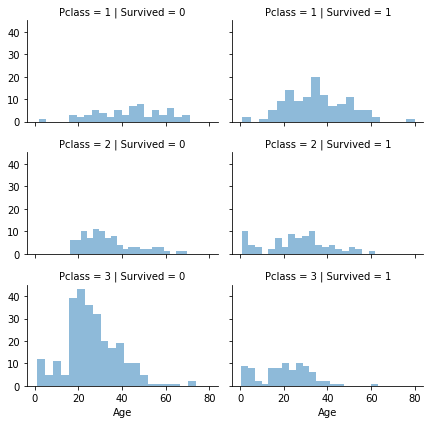

In [505]:
grid = sns.FacetGrid(df, col='Survived', row='Pclass', height=2, aspect=1.5)
grid.map(plt.hist, 'Age', alpha=.5, bins=20)
grid.add_legend()

Below you can see that embarked seems to be correlated with survival, depending on the gender.

Women on port Q and on port S have a higher chance of survival. The inverse is true, if they
are at port C. Men have a high survival probability if they are on port C, but a low probability
if they are on port Q or S.

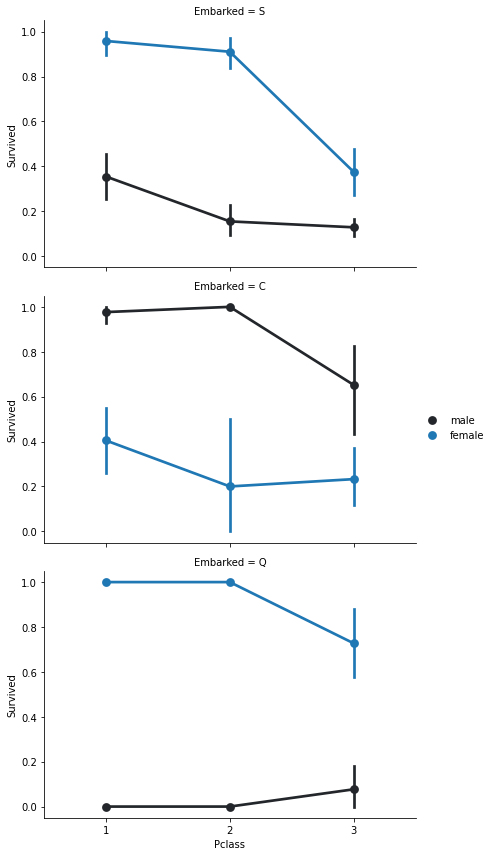

In [506]:
facet_grid = sns.FacetGrid(df, row='Embarked', height=4, aspect=1.5)
facet_grid.map(sns.pointplot, 'Pclass', 'Survived', 'Sex', hue_order=None, order=None)
facet_grid.add_legend()

# Dataset processing.

Below is a dataset base information.

In [507]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


After analyzing the base dataset information we can define a way to preprocess it.

In [508]:
def preprocess_titanic_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess titanic data.

    Drop useless columns, convert some features and interpolate an Age column.

    :param df: Titanic data to process.
    :return: Preprocessed `DateFrame`.
    """
    # First of all - make a copy of original data
    df = df.copy(deep=True)

    # In a titanic dataset we have a bunch of useless features.
    # There are such columns as Name, Ticket, Cabin and PassengerId.
    # So it is important to drop this information from the dataset.
    useless_columns = ['Name', 'Ticket', 'Cabin', 'PassengerId']
    df = df.drop(useless_columns, axis=1)

    # The next step is to define dummy varibles for Pclass, Sex and Embarked.
    # It is a way to convert them to columns in pandas.
    dummies = []
    columns_to_convert = ['Pclass', 'Sex', 'Embarked']
    for column in columns_to_convert:
        dummies.append(pd.get_dummies(df[column], prefix=column))

    # Concatenate dummies and titanic dataset.
    dummies = pd.concat(dummies, axis=1)
    df = pd.concat((df, dummies), axis=1)
    # Drop Pclass, Sex and Embarked because we already have this info as dummy variables.
    df = df.drop(columns_to_convert, axis=1)
    # Interpolate ages because this column has NaN values.
    df['Age'] = df['Age'].interpolate()

    return df

An original dataset after the preprocessing.

In [509]:
df = preprocess_titanic_data(df)
df.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0,22.0,1,0,7.2500,0,0,1,0,1,0,0,1
1,1,38.0,1,0,71.2833,1,0,0,1,0,1,0,0
2,1,26.0,0,0,7.9250,0,0,1,1,0,0,0,1
3,1,35.0,1,0,53.1000,1,0,0,1,0,0,0,1
4,0,35.0,0,0,8.0500,0,0,1,0,1,0,0,1


Prepare a dataset for training and divide it for a train and test sets (70% and 30% of the original dataset).

In [510]:
X_df = df.drop(['Survived'], axis=1).to_numpy()
y_df = df['Survived'].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=0)

Define models for classification and train them.

After that also we will get scores of trained models.

In [511]:
models = [LogisticRegression(max_iter=1000), KNeighborsClassifier(3), DecisionTreeClassifier(), SVC()]
model_scores_df = pd.DataFrame(columns=['Model', 'Score'])

for i, model in enumerate(models):
    model.fit(X=X_train, y=y_train)
    model_scores_df.loc[i] = [model.__class__.__name__,  np.round(model.score(X=X_test, y=y_test) * 100, 2)]

As you can see below, almost all algorithms are demonstrating
similar level of accuracy. It must be emphasised that in our case, LogisticRegression
is the most accurate classifier with about 80% accuracy for our test. And the worst one is
KNeighborsClassifier with about 70% accuracy.

In [512]:
model_scores_df.sort_values(by='Score', ascending=False)

,Model,Score
0,LogisticRegression,80.22
2,DecisionTreeClassifier,79.85
3,SVC,71.64
1,KNeighborsClassifier,69.78


# Check for overfitting.

1) Check models performance for training and test datasets.
We can define that KNeighborsClassifier and KNeighborsClassifier somewhat owerfitten.

In [513]:
model_scores_df = pd.DataFrame(columns=['Model', 'ScoreTrain', 'ScoreTest'])

for i, model in enumerate(models):
    scores = [np.round(model.score(X=X_train, y=y_train) * 100, 2), np.round(model.score(X=X_test, y=y_test) * 100, 2)]
    model_scores_df.loc[i] = [model.__class__.__name__] + scores

model_scores_df

,Model,ScoreTrain,ScoreTest
0,LogisticRegression,79.94,80.22
1,KNeighborsClassifier,82.02,69.78
2,DecisionTreeClassifier,98.72,79.85
3,SVC,66.29,71.64


2) R2 scores.
And yes. As we assumed on the previous step, such classifiers as KNeighborsClassifier, KNeighborsClassifier are overfitten
as well as SVC (but in the case of SVC, the overfitting level is slightly lower). We can prove it by comparing training
and test r2 scores provided below.

In [514]:
model_scores_df = pd.DataFrame(columns=['Model', 'Train R2 score', 'Test R2 score'])

for i, model in enumerate(models):
    y_train_predicted = model.predict(X_train)
    y_test_predicted = model.predict(X_test)
    scores = [r2_score(y_train, y_train_predicted), r2_score(y_test, y_test_predicted)]
    model_scores_df.loc[i] = [model.__class__.__name__] + scores

model_scores_df

,Model,Train R2 score,Test R2 score
0,LogisticRegression,0.155387,0.154524
1,KNeighborsClassifier,0.243227,-0.292143
2,DecisionTreeClassifier,0.945945,0.138571
3,SVC,-0.418950,-0.212381
